In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kge.model import KgeModel
from kge.util.io import load_checkpoint
from scipy.spatial.distance import cosine

In [12]:
# Load embeddings
model_path = '../../../Chapter2/analysis/experiments/selfloops/simple/20230929-111630-simple_selfloops/00021/checkpoint_best.pt'
checkpoint = load_checkpoint(model_path)
data_path = '/Users/fu19841/Documents/thesis_analysis/kge/data/selfloops'
checkpoint['config'].set('dataset.name', data_path)
model = KgeModel.create_from(checkpoint)

# Get node info
node_embeds = model.state_dict()['_entity_embedder._embeddings.weight']
node_list = pd.read_csv(
    checkpoint['config'].get('dataset.name') + '/entity_ids.del',
    sep='\t', header=None
)
node_name_to_index = {row[1]: row[0] for _, row in node_list.iterrows()}
node_index_to_name = {row[0]: row[1] for _, row in node_list.iterrows()}

Loading configuration of dataset /Users/fu19841/Documents/thesis_analysis/kge/data/selfloops from /Users/fu19841/Documents/thesis_analysis/kge/data/selfloops ...


In [14]:
# Load jaccard data
jaccard = pd.read_csv('stats/jaccard_indices.csv')
jaccard = jaccard.query('binary_jaccard > 0')  # Discard dyads with no shared targets

jaccard

,drug1,drug2,weighted_jaccard,normalised_jaccard,binary_jaccard
0,CID000005291,CID000004212,0.441903,0.526378,0.309524
1,CID000005291,CID005329102,0.375993,0.430565,0.226190
2,CID000005291,CID003062316,0.377514,0.487868,0.173077
3,CID000005291,CID000176870,0.152332,0.203302,0.152866
4,CID000005291,CID000123631,0.131880,0.192649,0.051282
...,...,...,...,...,...
37114,CID000148192,CID003002190,0.777778,0.775000,0.800000
37115,CID000148192,CID005353980,0.470588,0.426667,0.800000
37118,CID000130881,CID003002190,0.777778,0.775000,0.800000
37119,CID000130881,CID005353980,0.470588,0.426667,0.800000


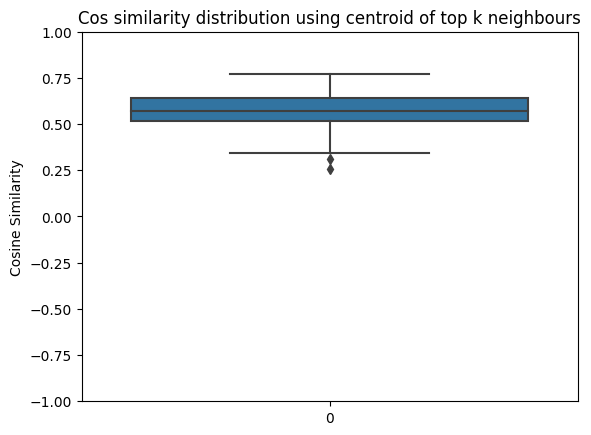

In [57]:
drugs = pd.concat([jaccard.drug1, jaccard.drug2]).unique()

k = 10  # Look at top k closest neighbours
vector_estimates = {}
for drug in drugs:
    query_df = jaccard.query(f'drug1 == "{drug}" or drug2 == "{drug}"')
    if len(query_df) >= k:  
        # Get vectors of closest neighbours
        query_df = query_df.sort_values('normalised_jaccard', ascending=False).reset_index(drop=True)
        vecs_to_aggregate = []
        for i, row in query_df.iterrows():
            if i >= k:
                break
            else:
                neighbour = row.drug2 if row.drug1 == drug else row.drug1
                neighbour_vec = node_embeds[node_name_to_index[neighbour]]
                vecs_to_aggregate.append(neighbour_vec)

        # Get centroid of the neighbour vectors
        centroid = []
        for j in range(len(vecs_to_aggregate[0])):
            mean_val = np.mean([vec[j] for vec in vecs_to_aggregate])
            centroid.append(mean_val)
        vector_estimates[drug] = centroid

# Compare estimated vecs with actual
results = []
for drug in vector_estimates:
    vec_est = vector_estimates[drug]
    vec_actual = node_embeds[node_name_to_index[drug]]
    cos = 1 - cosine(vec_est, vec_actual)
    results.append([drug, cos])
results = pd.DataFrame(results)

# Viz 
sns.boxplot(results[1])
plt.ylim((-1, 1))
plt.xlabel('')
plt.ylabel('Cosine Similarity')
plt.title('Cos similarity distribution using centroid of top k neighbours')
plt.show()


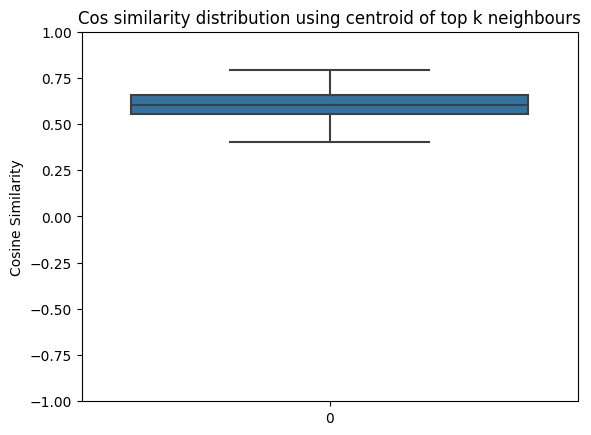

In [59]:
drugs = pd.concat([jaccard.drug1, jaccard.drug2]).unique()

vector_estimates = {}
for drug in drugs:
    query_df = jaccard.query(f'drug1 == "{drug}" or drug2 == "{drug}"')
    vecs_to_aggregate = []
    for _, row in query_df.iterrows():
        neighbour = row.drug2 if drug == row.drug1 else row.drug1
        neighbour_vec = node_embeds[node_name_to_index[neighbour]]
        vecs_to_aggregate.append(neighbour_vec)
    
    # Get average of components weighted by the jaccard similarity 
    centroid = []
    for j in range(len(vecs_to_aggregate[0])):
        vals = [vec[j] for vec in vecs_to_aggregate]
        weighted_mean_val = np.average(vals, weights=query_df.normalised_jaccard.values)
        centroid.append(weighted_mean_val)
    vector_estimates[drug] = centroid

# Compare estimated vecs with actual
results = []
for drug in vector_estimates:
    vec_est = vector_estimates[drug]
    vec_actual = node_embeds[node_name_to_index[drug]]
    cos = 1 - cosine(vec_est, vec_actual)
    results.append([drug, cos])
results = pd.DataFrame(results)

# Viz 
sns.boxplot(results[1])
plt.ylim((-1, 1))
plt.xlabel('')
plt.ylabel('Cosine Similarity')
plt.title('Cos similarity distribution using jaccard-weighted mean components')
plt.show()
